## Kernel Density Estimation

In [20]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
np.random.seed(24)

#### Dataset Generation

In [186]:
def generate_gaussian_samples(mu, sig, N):
    return np.random.normal(mu, sig, N)

mu0 = -2 #negative class instances distribution
mu1 = 2 #positive class instances distribution
sigma = 1 #standard deviation of both distributions

##### Training Set

In [187]:
N0 = int(20)
N1 = int(20)
S0 = generate_gaussian_samples(mu0, sigma, N0)
S1 = generate_gaussian_samples(mu1, sigma, N1)

##### Testing Set

In [188]:
N0_test = int(2e3)
N1_test = int(2e3)
S0_test = generate_gaussian_samples(mu0, sigma, N0_test)
S1_test = generate_gaussian_samples(mu1, sigma, N1_test)

## Method 1: Replace True Labels with Probabilities from KDE + Fitting LR
#### y = Score_Positive / (Score_positive + Score_negative)


## Method 2: Generate more points from KDE + LR fitting
#### Tryout Kernel Density Estimation for each class instances

In [189]:
#Kernel Bandwidth = n**(-1./(d+4)), with n the number of data points and d the number of dimensions
neg_kernel = stats.gaussian_kde(S0)
pos_kernel = stats.gaussian_kde(S1)

#### Method 1: Compute new true class probability based on kernel estimation.

In [190]:
P_S0 = pos_kernel.evaluate(S0) / (pos_kernel.evaluate(S0) + neg_kernel.evaluate(S0))
P_S1 = pos_kernel.evaluate(S1) / (pos_kernel.evaluate(S1) + neg_kernel.evaluate(S1))

#### Method 2: Generate new points to be used in fitting

In [191]:
N0_2 = int(N0 * 2)
N1_2 = int(N1 * 2)
neg2 = neg_kernel.resample(N0_2)
pos2 = pos_kernel.resample(N1_2)

X_train2 = np.array(np.concatenate((neg2.T, pos2.T), axis=0) )
y_train2 = np.asarray([0] * N0_2 + [1] * N1_2)

### Dataset Definition

In [192]:
X_train = np.array(np.concatenate((S0, S1), axis=0))
X_train = X_train[:, np.newaxis]

X_test = np.array(np.concatenate((S0_test, S1_test), axis=0))
X_test = X_test[:, np.newaxis]

y_train_prop = np.asarray(np.concatenate((P_S0, P_S1), axis=0))
y_train = np.asarray([0] * N0 + [1] * N1)
y_test = np.asarray([0] * N0_test + [1] * N1_test)

### Logistic Regression Model

In [193]:
class LR:
    def __init__(self, learnRate = 0.001, nIter = 1000, use_intercept = False):
        self.learnRate = learnRate
        self.nIter = nIter
        self.intercept = use_intercept
        
    def crossEntropy(self, P, Y):
        return (-Y * np.log(P) - (1 - Y) * np.log(1 - P)).mean()
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def SGD(self, X_train, y_train, X_test, y_test):
        #Add Intercept
        if self.intercept == True:
            X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
            X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
        #Initialize Weights by zeros
        self.Ws = np.zeros(X_train.shape[1])
        self.TrainLoss = []
        self.TestLoss = []
        #Update weights for n Iterations
        for i in range(self.nIter):
            if i % 500 == 0:
                print('Finished ', i, ' iterations')
            #Shuffle indeces
            p = np.random.permutation(len(X_train))
            X_train = X_train[p]
            y_train = y_train[p]
            for row,y_t in zip(X_train, y_train):
                Z = np.dot(row, self.Ws)
                y_p = self.sigmoid(Z)
                gradient = np.dot(row.T, (y_p - y_t))
                self.Ws -= self.learnRate * gradient
            
            Z = np.dot(X_train, self.Ws)
            y_pred = self.sigmoid(Z)
            self.TrainLoss.append(self.crossEntropy(y_pred, y_train))
            
            ZTest = np.dot(X_test, self.Ws)
            yTest_pred = self.sigmoid(ZTest)
            self.TestLoss.append(self.crossEntropy(yTest_pred, y_test))
    
    def predict_prob(self, X):
        #Add Intercept
        if self.intercept == True:
            intercept = np.ones((X.shape[0], 1))
            X = np.concatenate((intercept, X), axis=1)
        return self.sigmoid(np.dot(X, self.Ws))
    
    def predict(self, X, threshold = 0.5):
        return self.predict_prob(X) >= threshold

#### Method1: Fit LR model using modified / new true class probabilities

In [194]:
iterations = 2000
LRate = 0.001
model1 = LR(learnRate = LRate, nIter = iterations, use_intercept = False)
model1.SGD(X_train, y_train_prop, X_test, y_test)

Finished  0  iterations
Finished  500  iterations
Finished  1000  iterations
Finished  1500  iterations


#### Original LR: Fit LR model using true class labels

In [195]:
model = LR(learnRate = LRate, nIter = iterations, use_intercept = False)
model.SGD(X_train, y_train, X_test, y_test)

Finished  0  iterations
Finished  500  iterations
Finished  1000  iterations
Finished  1500  iterations


#### Sklearn LR:

In [196]:
model_sklearn = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

#### Method2: Fit LR model using new generated instances

In [197]:
model2 = LR(learnRate = LRate, nIter = iterations, use_intercept = False)
model2.SGD(X_train2, y_train2, X_test, y_test)

Finished  0  iterations
Finished  500  iterations
Finished  1000  iterations
Finished  1500  iterations


#### Plot CE Loss

Text(0.5, 1.0, 'CE Loss on Training/Testing Set using SGD')

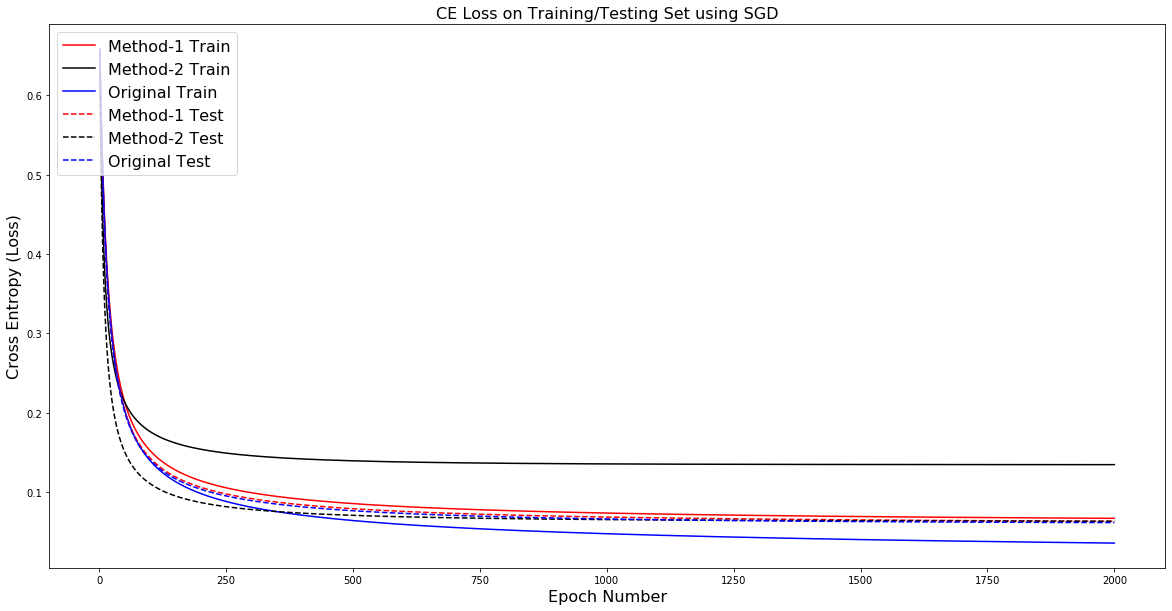

In [198]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(20,10)) 

plt.plot(list(range(1,iterations + 1)), (model1.TrainLoss), 'r', label = 'Method-1 Train')
plt.plot(list(range(1,iterations + 1)), (model2.TrainLoss), 'k', label = 'Method-2 Train')
plt.plot(list(range(1,iterations + 1)), (model.TrainLoss), 'b', label = 'Original Train')

plt.plot(list(range(1,iterations + 1)), (model1.TestLoss), 'r--', label = 'Method-1 Test')
plt.plot(list(range(1,iterations + 1)), (model2.TestLoss), 'k--', label = 'Method-2 Test')
plt.plot(list(range(1,iterations + 1)), (model.TestLoss), 'b--', label = 'Original Test')

plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 16)
plt.ylabel('Cross Entropy (Loss)', fontsize = 16)
plt.title('CE Loss on Training/Testing Set using SGD', fontsize = 16)

### Predict on Test Set and Measure Accuracy & CE Loss

In [199]:
y_pred = model.predict_prob(X_test)
CE_old = model.crossEntropy(y_pred, y_test)
y_pred_new1 = model1.predict_prob(X_test)
CE_new1 = model1.crossEntropy(y_pred_new1, y_test)
y_pred_new2 = model2.predict_prob(X_test)
CE_new2 = model2.crossEntropy(y_pred_new2, y_test)

y_pred_sklearn = model_sklearn.predict_proba(X_test)
CE_sklearn = model.crossEntropy(y_pred_sklearn[:,1], y_test)

y_pred_labels = model.predict(X_test)
y_pred_labels_new1 = model1.predict(X_test)
y_pred_labels_new2 = model2.predict(X_test)
y_pred_sklearn_labels = model_sklearn.predict(X_test)
print('Original LR: Accuracy: ', accuracy_score(y_test, y_pred_labels)*100, '%, Test Cross Entropy: ', CE_old)
print('Sklearn LR: Accuracy: ', accuracy_score(y_test, y_pred_sklearn_labels)*100, '%, Test Cross Entropy: ', CE_sklearn)
print('Method 1 LR: Accuracy = ', accuracy_score(y_test, y_pred_labels_new1)*100, '%, Test Cross Entropy: ', CE_new1)
print('Method 2 LR: Accuracy = ', accuracy_score(y_test, y_pred_labels_new2)*100, '%, Test Cross Entropy: ', CE_new2)

Original LR: Accuracy:  97.8 %, Test Cross Entropy:  0.06169953432533062
Sklearn LR: Accuracy:  97.175 %, Test Cross Entropy:  0.09364041906374536
Method 1 LR: Accuracy =  97.8 %, Test Cross Entropy:  0.06340508022295419
Method 2 LR: Accuracy =  97.8 %, Test Cross Entropy:  0.06341352592338838


In [200]:
wrong = 0
true = 0
for y1, y2, X, y in zip(y_pred_labels_new2, y_pred_labels, X_test, y_test):
    if y1 != y2:
        print(y1, y2, X, y)
        wrong += 1
    else:
        true+=1
        
print(wrong, true)

0 4000


In [201]:
y_test

array([0, 0, 0, ..., 1, 1, 1])